<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/MNIST_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/jaekookang/mnist-grad-cam/blob/master/mnist_grad_cam.ipynb

上記のプログラムを参考にした。


*   tensorflow は微分の扱いが 2.5あたりから変わっているのでそれに対応
*   GradientTape を使う。かなりコードの改変が必要



In [1]:
import keras
keras.__version__

'2.6.0'

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
# from train import prepare_mnist
from time import strftime, gmtime


In [6]:
class HParam:
    batch_size = 128
    num_classes = 10
    epochs = 10

hp = HParam()

def build_cnn(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, (3,3), activation='relu')(x)
    h = Conv2D(64, (3,3), activation='relu')(h)
    h = MaxPool2D(pool_size=(2,2))(h)
    h = Dropout(0.5)(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(0.5)(h)
    y = Dense(hp.num_classes, activation='softmax')(h)
    model = Model(inputs=[x], outputs=[y])
    return model

def train():
    # Get mnist dataset
    # (x_train, y_train), (x_test, y_test), input_shape = prepare_mnist()
    # Build & compile model
    model = build_cnn(input_shape)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    # Run model
    hist = model.fit(x_train, y_train,
                     batch_size=hp.batch_size,
                     epochs=hp.epochs,
                     verbose=1,
                     validation_data=(x_test, y_test))
    # Test model
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')
    # Save model
    model.save(f'model/mnist_{get_date()}')
    print('Model saved!')
    return hist,model

def get_date():
    return strftime('%Y-%m-%d', gmtime())

def prepare_mnist():
    # Prepare mnist dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    nrow, ncol = 28, 28
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, nrow, ncol)
        x_test = x_test.reshape(x_test.shape[0], 1, nrow, ncol)
        input_shape = (1, nrow, ncol)
    else:
        x_train = x_train.reshape(x_train.shape[0], nrow, ncol, 1)
        x_test = x_test.reshape(x_test.shape[0], nrow, ncol, 1)
        input_shape = (nrow, ncol, 1)
    # Change variable type, value range
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    # Convert classes into one-hot vector
    y_train = keras.utils.np_utils.to_categorical(y_train, hp.num_classes)
    y_test = keras.utils.np_utils.to_categorical(y_test, hp.num_classes)
    return (x_train, y_train), (x_test, y_test), input_shape

In [7]:
(x_train, y_train), (x_test, y_test), input_shape = prepare_mnist()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
# !wget -O mnist_2019-06-02 https://github.com/jaekookang/mnist-grad-cam/blob/master/model/mnist_2019-06-02?raw=true

In [9]:
hist, model = train()

Epoch 1/10
469/469 [==============================] - 4s 5ms/step - loss: 0.2563 - accuracy: 0.9225 - val_loss: 0.0537 - val_accuracy: 0.9836
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0951 - accuracy: 0.9719 - val_loss: 0.0369 - val_accuracy: 0.9886
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0715 - accuracy: 0.9785 - val_loss: 0.0335 - val_accuracy: 0.9883
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0606 - accuracy: 0.9813 - val_loss: 0.0320 - val_accuracy: 0.9892
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0524 - accuracy: 0.9841 - val_loss: 0.0288 - val_accuracy: 0.9899
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0479 - accuracy: 0.9850 - val_loss: 0.0293 - val_accuracy: 0.9907
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.0267 - val_accuracy: 0.9913
Epoch 

In [10]:
model.evaluate(x_test, y_test, verbose=0)

[0.027814606204628944, 0.9911999702453613]

# 99%!

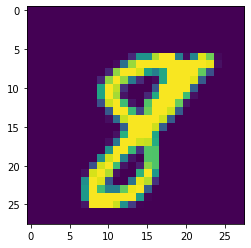

In [11]:
x_train = x_train.squeeze()
test_img = x_train[55]
plt.imshow(test_img)

In [12]:
model =load_model(f'model/mnist_{get_date()}')
model.summary()
# 畳み込み層を取り出すためのダミーモデル
layer_outputs = [layer.output for layer in model.layers[1:3]]
# Create a model returning the layer_outputs for the model input
act_model = Model(inputs=model.input, outputs=layer_outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               117977

In [13]:
activations = act_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],1))
[print(act.shape) for act in activations];

(1, 26, 26, 32)
(1, 24, 24, 64)


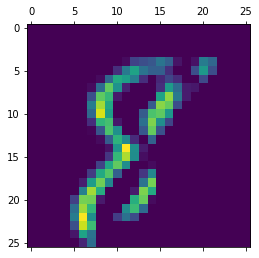

In [14]:
plt.matshow(activations[0][0,:,:,31], cmap='viridis')

In [15]:
# Make grid plots
def plot_conv_layer(which_conv):
    # Plot conv layer activation
    # which_conv = 0 # 0=first, 1=second
    img_per_row = 10
    n_feat = activations[which_conv].shape[-1] # number of feature maps
    size = activations[which_conv].shape[1] # image feature (e.g., 26)
    n_col = np.round(n_feat/img_per_row).astype('int')
    display_grid = np.zeros((size*n_col, img_per_row*size))
    # Add each filter into the grids
    for col in range(n_col):
        for row in range(img_per_row):
            if col*img_per_row+row < size:
                img = activations[which_conv][0,:,:,col*img_per_row+row]
                # Post-process images
                img -= img.mean()
                img -= img.std()
                img *= 64
                img += 128
                img = np.clip(img, 0, 255).astype('uint8')
                display_grid[col*size:(col+1)*size,
                             row*size:(row+1)*size] = img
    scale = 1/size
    fig, ax = plt.subplots(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    ax.set_title(f'ConvLayer = {which_conv+1}')
    ax.grid(False)
    ax.imshow(display_grid, aspect='auto', cmap='viridis')
    return fig, ax

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccb2024750>)

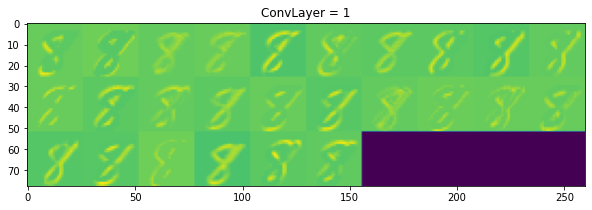

In [16]:
plot_conv_layer(0)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcc94af2f10>)

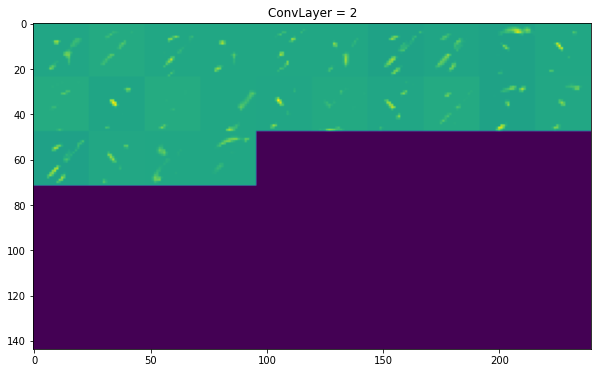

In [17]:
plot_conv_layer(1)

# Visualize Grad-CAM
Grad-CAM visualizes input features that are most likely to generate the target.

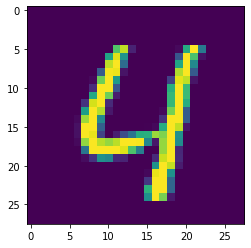

In [139]:
which_number = 4
# Convert ont-hot vector to integer
y_test_int = np.where(y_test==1)[1]
# Randomly select one example
rand_idx = np.random.choice(np.where(y_test_int == which_number)[0])
test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],1)
# Visualize test_input
plt.imshow(test_input.squeeze());

In [140]:
import tensorflow as tf
# Get output vector
# Get the last convolutional layer

# Get the gradient of the given number with regard to the output feature map of the last conv layer
last_conv_layer = model.layers[2]
grad_model = Model([model.inputs], [last_conv_layer.output, model.output])
tftest = tf.Variable(tf.cast(test_input,tf.float32))
with tf.GradientTape(persistent=True) as tp:
  conv_outputs, predictions = grad_model(np.array(tftest))
  loss = predictions[:,which_number]
# output = conv_outputs[0]
grads = tp.gradient(loss, conv_outputs)[0] # (None,24,24,64)
# Get the mean intensity of the gradient over each feature map (64)
# pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 64
pooled_grads = K.mean(grads, axis=(0, 1)) # 64
# Calculate channel-wise mean for the heatmap activation
heatmaps = conv_outputs.numpy()[0]
for i in range(len(pooled_grads)):
    heatmaps[:,:,i] *= pooled_grads[i]
# Calculate channel-wise mean for the heatmap activation
heatmap = np.mean(heatmaps, axis=-1)

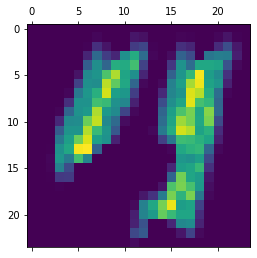

In [141]:
heatmap = np.maximum(heatmap, 0) # => max(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [142]:
# Add 3 channels for coloring the heatmap
img_size = (500, 500)
# Prepare image
test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
test_input_resized *= 255
test_input_resized = test_input_resized.astype(np.uint8)
test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)

# Make heatmap
heatmap_resized = cv2.resize(heatmap, img_size) # (500, 500)
heatmap_resized = np.uint8(255*heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
# Apply heatmap on the original image
superimposed_img = heatmap_resized*0.7 + 0.3*test_input_resized
# Save
cv2.imwrite('test.jpg', superimposed_img);

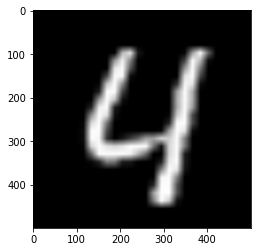

In [143]:
plt.imshow(test_input_resized)

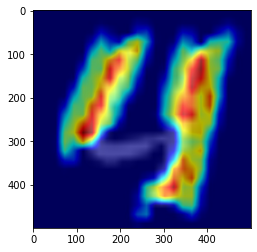

In [144]:
img = mpimg.imread('test.jpg')
plt.imshow(img)

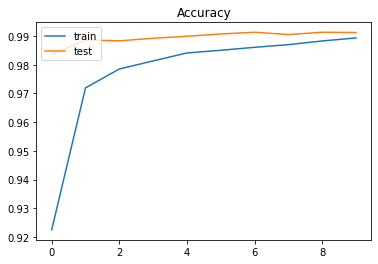

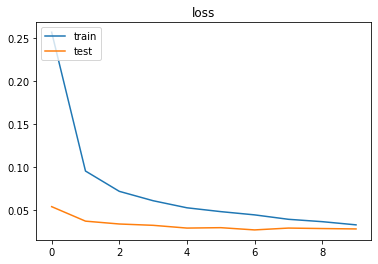

In [149]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()